Step 1: Installation (Run in a new cell)

In [4]:
!pip install aif360
!pip install pandas matplotlib seaborn scikit-learn
!pip install tensorflow


Load and Preprocess Your Data

In [18]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("fraud_data.csv")

# Preview the data
print("Initial Data Sample:")
print(df.head())

# Convert categorical to numerical
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Fraud_risk'] = df['Fraud_risk'].map({'Safe': 0, 'Risk': 1})

print("\nAfter Encoding:")
print(df.head())


Initial Data Sample:
  Gender Married  Education Fraud_risk
0   Male      No          1       Risk
1   Male     Yes          1       Safe
2   Male     Yes          1       Safe
3   Male     Yes          0       Safe
4   Male      No          1       Risk

After Encoding:
   Gender  Married  Education  Fraud_risk
0       1        0          1           1
1       1        1          1           0
2       1        1          1           0
3       1        1          0           0
4       1        0          1           1


Convert to AIF360 Dataset Format

In [19]:
from aif360.datasets import BinaryLabelDataset

# Define privileged and unprivileged groups
privileged_groups = [{'Gender': 1}]
unprivileged_groups = [{'Gender': 0}]

# Prepare the dataset
dataset = BinaryLabelDataset(
    df=df,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)


 Fairness Metrics Before Mitigation

In [20]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Group fairness metrics
metric_orig = BinaryLabelDatasetMetric(dataset, unprivileged_groups, privileged_groups)
print("Disparate Impact:", metric_orig.disparate_impact())
print("Statistical Parity Difference:", metric_orig.statistical_parity_difference())
print("Mean Difference:", metric_orig.mean_difference())


Disparate Impact: 2.2360437943569327
Statistical Parity Difference: 0.37274720398815037
Mean Difference: 0.37274720398815037


In [24]:
metric = BinaryLabelDatasetMetric(dataset_train,
                                   unprivileged_groups=[{protected_attribute: 0}],
                                   privileged_groups=[{protected_attribute: 1}])

print("### Fairness Metrics ###")
print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Mean Difference:", metric.mean_difference())


### Fairness Metrics ###
Disparate Impact: nan
Statistical Parity Difference: nan
Mean Difference: nan


In [23]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split original data
X = df.drop(columns=["Fraud_risk"])
y = df["Fraud_risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Reconstruct test dataframe with correct structure
X_test_copy = X_test.copy()
X_test_copy['Fraud_risk'] = y_pred  # predicted labels

# Create predicted BinaryLabelDataset
dataset_pred = BinaryLabelDataset(
    df=X_test_copy,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)

# For comparison, create BinaryLabelDataset of true labels for the same test set
X_test_true = X_test.copy()
X_test_true['Fraud_risk'] = y_test.values  # true labels

dataset_true = BinaryLabelDataset(
    df=X_test_true,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)

# Fairness metric: compare predicted vs true
metric_pred = ClassificationMetric(dataset_true, dataset_pred, unprivileged_groups, privileged_groups)
print("Disparate Impact After Model:", metric_pred.disparate_impact())
print("Equal Opportunity Difference:", metric_pred.equal_opportunity_difference())
print("Average Odds Difference:", metric_pred.average_odds_difference())


Disparate Impact After Model: 2.784283112151965
Equal Opportunity Difference: 0.29032258064516125
Average Odds Difference: 0.31840690435766833


In [25]:
from aif360.algorithms.preprocessing import Reweighing

# Create the original dataset again (before train/test split)
dataset_orig = BinaryLabelDataset(
    df=df,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)

# Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

# Now split dataset_transf into train/test manually (since it's an AIF360 object)
df_transf = dataset_transf.convert_to_dataframe()[0]

# Split manually
X_rw = df_transf.drop(columns=["Fraud_risk"])
y_rw = df_transf["Fraud_risk"]
weights_rw = dataset_transf.instance_weights

X_train_rw, X_test_rw, y_train_rw, y_test_rw, weights_train_rw, weights_test_rw = train_test_split(
    X_rw, y_rw, weights_rw, test_size=0.3, random_state=42)

# Scale features
X_train_rw_scaled = scaler.fit_transform(X_train_rw)
X_test_rw_scaled = scaler.transform(X_test_rw)

# Train classifier with instance weights
model_rw = LogisticRegression()
model_rw.fit(X_train_rw_scaled, y_train_rw, sample_weight=weights_train_rw)

# Predict on test
y_pred_rw = model_rw.predict(X_test_rw_scaled)

# Reconstruct predicted and true datasets for metric comparison
X_test_rw_copy = X_test_rw.copy()
X_test_rw_copy['Fraud_risk'] = y_pred_rw

X_test_rw_true = X_test_rw.copy()
X_test_rw_true['Fraud_risk'] = y_test_rw.values

# Convert both to BinaryLabelDataset
dataset_rw_pred = BinaryLabelDataset(
    df=X_test_rw_copy,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)

dataset_rw_true = BinaryLabelDataset(
    df=X_test_rw_true,
    label_names=['Fraud_risk'],
    protected_attribute_names=['Gender']
)

# Fairness Metrics after Reweighing
metric_rw = ClassificationMetric(dataset_rw_true, dataset_rw_pred,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)

print("After Reweighing:")
print("Disparate Impact:", metric_rw.disparate_impact())
print("Equal Opportunity Difference:", metric_rw.equal_opportunity_difference())
print("Average Odds Difference:", metric_rw.average_odds_difference())


After Reweighing:
Disparate Impact: 1.3799603174603174
Equal Opportunity Difference: -0.18238213399503722
Average Odds Difference: -0.025401593313308088


In [27]:
from aif360.algorithms.postprocessing import RejectOptionClassification

# Use dataset_rw_true and dataset_rw_pred from Step 6 as input
# ROC expects: original dataset (true labels) and classified dataset (predictions)

ROC = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    low_class_thresh=0.01,   # Lower bound threshold for positive class
    high_class_thresh=0.99,  # Upper bound threshold for positive class
    num_class_thresh=100,    # Number of thresholds for classification boundary search
    num_ROC_margin=50,       # Margin size for ROC algorithm
    metric_name="Statistical parity difference"
)

# Fit ROC postprocessor
ROC = ROC.fit(dataset_rw_true, dataset_rw_pred)

# Apply ROC to adjust predictions
dataset_roc_pred = ROC.predict(dataset_rw_pred)

# Evaluate fairness metrics after ROC postprocessing
metric_roc = ClassificationMetric(dataset_rw_true, dataset_roc_pred,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("After Reject Option Classification (ROC):")
print("Disparate Impact:", metric_roc.disparate_impact())
print("Equal Opportunity Difference:", metric_roc.equal_opportunity_difference())
print("Average Odds Difference:", metric_roc.average_odds_difference())


After Reject Option Classification (ROC):
Disparate Impact: 1.3799603174603174
Equal Opportunity Difference: -0.18238213399503722
Average Odds Difference: -0.025401593313308088


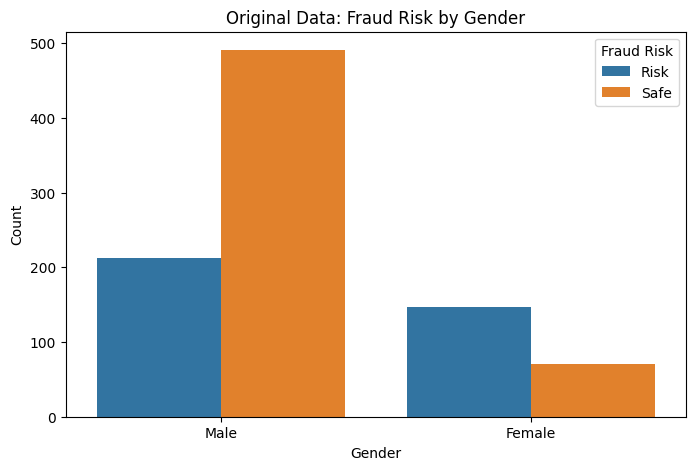

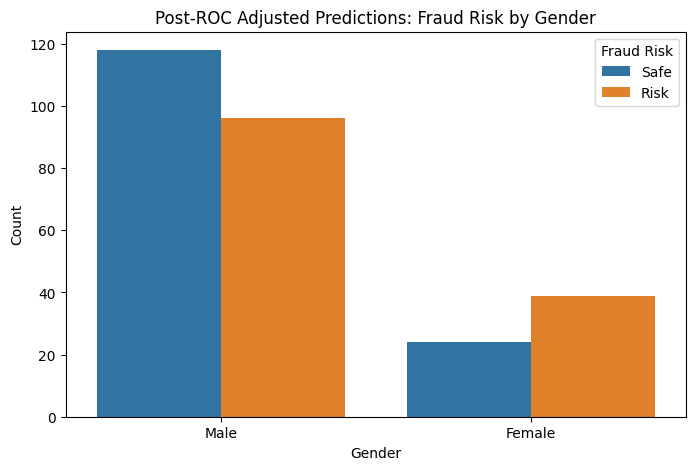

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot original dataset: Fraud Risk by Gender
plt.figure(figsize=(8,5))
sns.countplot(x="Gender", hue="Fraud_risk", data=df.replace({'Gender': {1: 'Male', 0: 'Female'},
                                                           'Fraud_risk': {1: 'Risk', 0: 'Safe'}}))
plt.title("Original Data: Fraud Risk by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Fraud Risk")
plt.show()

# Plot predicted outcomes after ROC by Gender
df_roc = dataset_roc_pred.convert_to_dataframe()[0]

plt.figure(figsize=(8,5))
sns.countplot(x="Gender", hue="Fraud_risk", data=df_roc.replace({'Gender': {1: 'Male', 0: 'Female'},
                                                                'Fraud_risk': {1: 'Risk', 0: 'Safe'}}))
plt.title("Post-ROC Adjusted Predictions: Fraud Risk by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Fraud Risk")
plt.show()


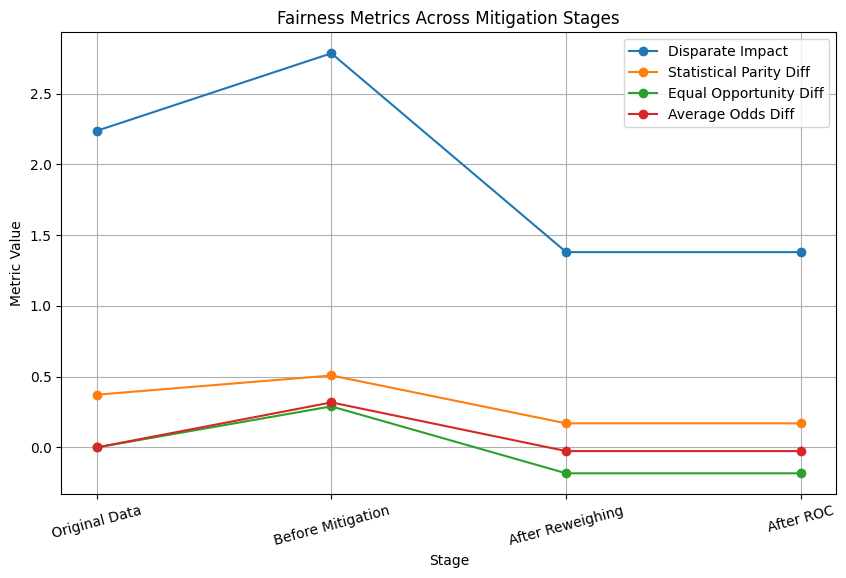

In [30]:
import numpy as np

# Define function to extract metrics easily
def get_metrics(true_dataset, pred_dataset):
    metric = ClassificationMetric(true_dataset, pred_dataset,
                                 unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)
    return {
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Diff": metric.statistical_parity_difference(),
        "Equal Opportunity Diff": metric.equal_opportunity_difference(),
        "Average Odds Diff": metric.average_odds_difference()
    }

# Prepare datasets for comparison
# Original data vs itself (no prediction, just baseline)
dataset_orig_pred = dataset_orig.copy()  # pretend predicted == true

# Get metrics at each stage
metrics = {
    "Original Data": get_metrics(dataset_orig, dataset_orig_pred),
    "Before Mitigation": get_metrics(dataset_rw_true, dataset_pred),
    "After Reweighing": get_metrics(dataset_rw_true, dataset_rw_pred),
    "After ROC": get_metrics(dataset_rw_true, dataset_roc_pred)
}

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(metrics).T

# Plot line graph for each metric
plt.figure(figsize=(10,6))
for col in metrics_df.columns:
    plt.plot(metrics_df.index, metrics_df[col], marker='o', label=col)

plt.title("Fairness Metrics Across Mitigation Stages")
plt.xlabel("Stage")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)
plt.show()


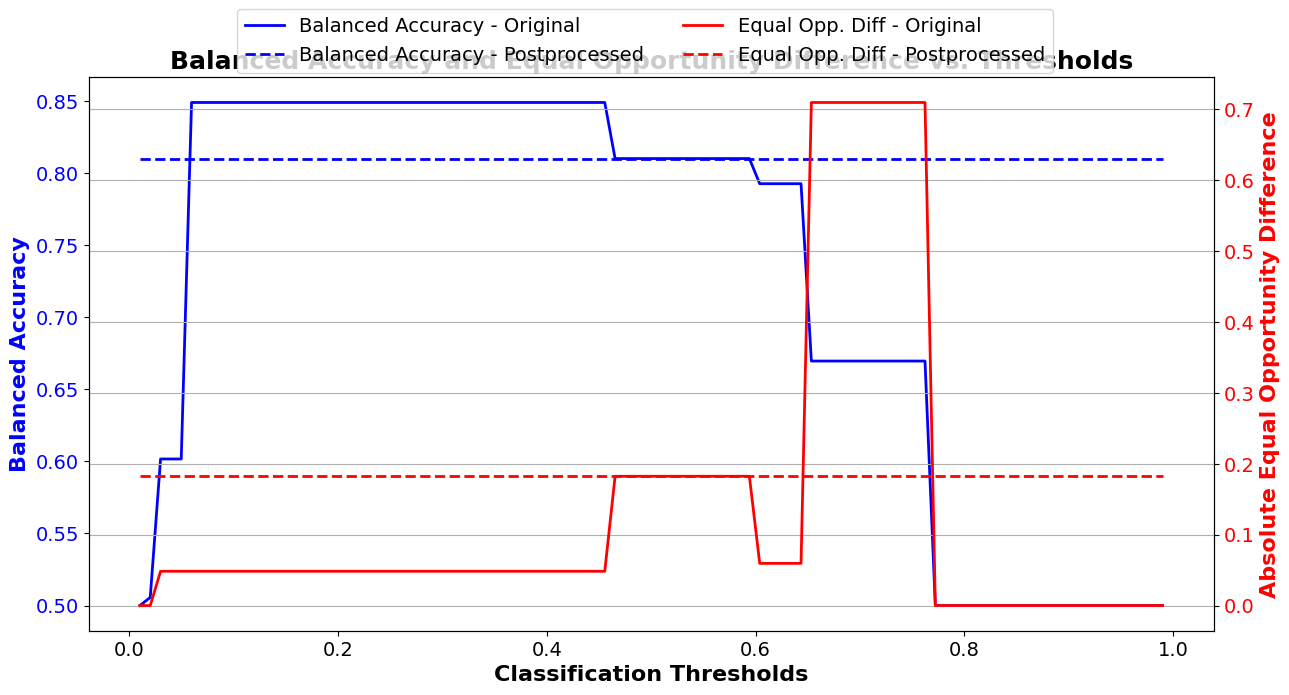

In [32]:
from sklearn.metrics import balanced_accuracy_score
from aif360.metrics import ClassificationMetric

# Define thresholds from 0.01 to 0.99
all_thresh = np.linspace(0.01, 0.99, 100)

# Arrays to store results
bef_bal_acc_valid = []
aft_bal_acc_valid = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_valid = []

# True labels and features from test set (used in Step 5/6)
y_test_true = y_test_rw.values  # ground truth
y_probs_before = model_rw.predict_proba(X_test_rw_scaled)[:, 1]  # before mitigation
y_probs_after = ROC.predict(dataset_rw_pred).scores  # postprocessed scores

for thresh in all_thresh:
    # Threshold predictions before mitigation
    y_pred_before = (y_probs_before >= thresh).astype(int)

    # Threshold predictions after ROC mitigation
    y_pred_after = (y_probs_after >= thresh).astype(int)

    # Prepare predicted datasets
    df_before = X_test_rw.copy()
    df_before['Fraud_risk'] = y_pred_before

    df_after = X_test_rw.copy()
    df_after['Fraud_risk'] = y_pred_after

    dataset_before = BinaryLabelDataset(
        df=df_before,
        label_names=['Fraud_risk'],
        protected_attribute_names=['Gender']
    )
    
    dataset_after = BinaryLabelDataset(
        df=df_after,
        label_names=['Fraud_risk'],
        protected_attribute_names=['Gender']
    )
    
    # True dataset
    df_true = X_test_rw.copy()
    df_true['Fraud_risk'] = y_test_true
    dataset_true = BinaryLabelDataset(
        df=df_true,
        label_names=['Fraud_risk'],
        protected_attribute_names=['Gender']
    )

    # Fairness metrics
    metric_before = ClassificationMetric(dataset_true, dataset_before, unprivileged_groups, privileged_groups)
    metric_after = ClassificationMetric(dataset_true, dataset_after, unprivileged_groups, privileged_groups)

    # Append balanced accuracy and equal opportunity difference
    bef_bal_acc_valid.append(balanced_accuracy_score(y_test_true, y_pred_before))
    aft_bal_acc_valid.append(balanced_accuracy_score(y_test_true, y_pred_after))

    bef_avg_odds_diff_valid.append(metric_before.equal_opportunity_difference())
    aft_avg_odds_diff_valid.append(metric_after.equal_opportunity_difference())
# Convert lists to numpy arrays
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
aft_bal_acc_valid = np.array(aft_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))

# Balanced Accuracy
ax1.plot(all_thresh, bef_bal_acc_valid, color='blue', label='Balanced Accuracy - Original', linewidth=2)
ax1.plot(all_thresh, aft_bal_acc_valid, color='blue', linestyle='--', label='Balanced Accuracy - Postprocessed', linewidth=2)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='blue', fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Equal Opportunity Diff
ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='red', label='Equal Opp. Diff - Original', linewidth=2)
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='red', linestyle='--', label='Equal Opp. Diff - Postprocessed', linewidth=2)
ax2.set_ylabel('Absolute Equal Opportunity Difference', color='red', fontsize=16, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)

# Title and legend
plt.title('Balanced Accuracy and Equal Opportunity Difference vs. Thresholds', fontsize=18, fontweight='bold')
ax2.grid(True)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

fig.legend(lines, labels, loc='upper center', ncol=2, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 📌 Recommendations
- Collect more diverse data (include more female samples).
- Use preprocessing methods like reweighing.
- Regularly audit model fairness with AIF360.

## ⚖️ Ethics Framework
- Transparency in feature selection.
- Justify model predictions to users.
- Build inclusive datasets and continuously monitor fairness.

## 🔗 Real-World Implications
Bias in fraud detection can lead to unjust denial of services or flagging based on gender. Mitigating bias ensures fairer financial service delivery.
